# Imports and definitions

In [1]:
import pandas as pd
import torch
import torchvision.transforms.functional as transform
import torchvision.transforms.functional as F
from EnsembleXAI import Ensemble, Metrics
from torchvision.transforms import Resize, CenterCrop
import os
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import urllib.request
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients, Occlusion, NoiseTunnel, visualization as viz, Saliency
import matplotlib.pyplot as plt
import pickle

In [2]:
with urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json") as url:
    imagenet_classes_dict = json.load(url)
with urllib.request.urlopen("https://raw.githubusercontent.com/LUSSeg/ImageNet-S/main/data/categories/ImageNetS_categories_im50.txt") as url:
    imagenetS50_ids_dict = {str(x).replace("b'", "").replace("\\n'", "").replace("'",""):i+1 for i, x in enumerate(url)}

In [3]:
def download_class_images(class_id, masks_path):
    full_path = masks_path + class_id + "\\"
    kaggle_path = f"/ILSVRC/Data/CLS-LOC/train/{class_id}/"
    for file_name in os.listdir(full_path):
        file_name_jpeg = file_name[:-3] + 'JPEG'
        !kaggle competitions download -f {kaggle_path}{file_name_jpeg} -p ./images/{class_id}/ -c imagenet-object-localization-challenge


def download():
    skipped = []
    for class_id in os.listdir(masks_dir):
        image_class_path = os.path.join(images_dir, class_id)
        if os.path.exists(image_class_path) and len(os.listdir(image_class_path)) == 10:
            skipped.append(class_id)
            continue
        #download_class_images(class_id, masks_dir)
        print(f"Downloaded {class_id}")
    print("Full dirs: " + str(len(skipped)))


def images_list(image_path, resize=True):
    _crop = CenterCrop(224).forward
    _resize = Resize(232).forward
    images = []
    for image_name in os.listdir(image_path):
        image = Image.open(image_path + image_name)
        if image.mode == 'L':
            image = image.convert(mode='RGB')
        if resize:
            image = _crop(_resize(image))
        images.append(image)
    return images

def load_all(classid):
    all_img = images_list(images_dir + classid + "\\")
    all_img_org = images_list(images_dir + classid + "\\", resize=False)
    all_tens = [F.to_tensor(img) for img in all_img]
    all_msks = [F.pil_to_tensor(img) for img in images_list(masks_dir + classid + "\\")]
    all_msks = [((temp[1] * 256 + temp[0]) == imagenetS50_ids_dict[classid]).float().repeat(3,1,1) for temp in all_msks]
    all_tens = [tens.repeat(3,1,1) if tens.shape[0]==1 else tens for tens in all_tens]
    tens_img = torch.stack(all_tens)
    tens_msks = torch.stack(all_msks)#[:,0].unsqueeze(dim=1).repeat(1, tens_img.shape[1], 1, 1)
    return all_img, all_img_org, all_tens, all_msks, tens_img, tens_msks

def dict_to_matrix(original_data, explanations_dict, predictor, masks_tensor):
    df = pd.DataFrame()
    #impact_thresh = 0.4
    #accordance_thresh = 0.2
    for key, value in explanations_dict.items():
        for thresh in range(10):
            thresh_val = thresh/10
            df.loc[key, f"DIR{thresh_val}"] = Metrics.decision_impact_ratio(original_data, predictor, value, thresh_val, 0)
            df.loc[key, f"CIR Same{thresh_val}"] = Metrics.confidence_impact_ratio(original_data, predictor, value, thresh_val, 0, compare_to="same_prediction")
            df.loc[key, f"CIR Max{thresh_val}"] = Metrics.confidence_impact_ratio(original_data, predictor, value, thresh_val, 0, compare_to="new_prediction")
            df.loc[key, f"Average Recall{thresh_val}"] = torch.mean(Metrics.accordance_recall(value, masks_tensor, thresh_val)).item()
            df.loc[key, f"Average Precision{thresh_val}"] = torch.mean(Metrics.accordance_precision(value, masks_tensor, thresh_val)).item()
            df.loc[key, f"F1_score{thresh_val}"] = Metrics.F1_score(explanations_dict[key], masks_tensor, thresh_val)
            df.loc[key, f"IOU{thresh_val}"] = Metrics.intersection_over_union(explanations_dict[key], masks_tensor, thresh_val)
    return df

# Images load

In [4]:
input_dir = "\\".join(os.getcwd().split(sep="\\")[:-2] + ['input'])
masks_dir = input_dir + f'\\ImageNetS50\\train-semi-segmentation\\'
images_dir = os.getcwd() + "\\images\\"
all_classes = next(os.walk(images_dir))[1]
print(all_classes)

['n01443537', 'n01491361', 'n01531178', 'n01644373', 'n02104029', 'n02119022', 'n02123597', 'n02133161', 'n02165456', 'n02281406', 'n02325366', 'n02342885', 'n02396427', 'n02483362', 'n02504458', 'n02510455', 'n02690373', 'n02747177', 'n02783161', 'n02814533', 'n02859443', 'n02917067', 'n02992529', 'n03014705', 'n03047690', 'n03095699', 'n03197337', 'n03201208', 'n03445777', 'n03452741', 'n03584829', 'n03630383', 'n03775546', 'n03791053', 'n03874599', 'n03891251', 'n04026417', 'n04335435', 'n04380533', 'n04404412', 'n04447861', 'n04507155', 'n04522168', 'n04557648', 'n04562935', 'n04612504', 'n06794110', 'n07749582', 'n07831146', 'n12998815']


do 36 włącznie było bez f1/iou według thresholdu, puscic jakis skrypt robiacy to i zastepujace nany zerami, i drugi .csv dla roznych thresholdów, od 40tego włącznie juz dobrze

In [5]:
id = all_classes[10] #n02325366
print(id)
if not os.path.exists(f'results/{id}'):
    os.mkdir(f'results/{id}')
all_images, all_images_original, all_tensors, all_masks, tensor_images, tensor_masks = load_all(id)

n02325366


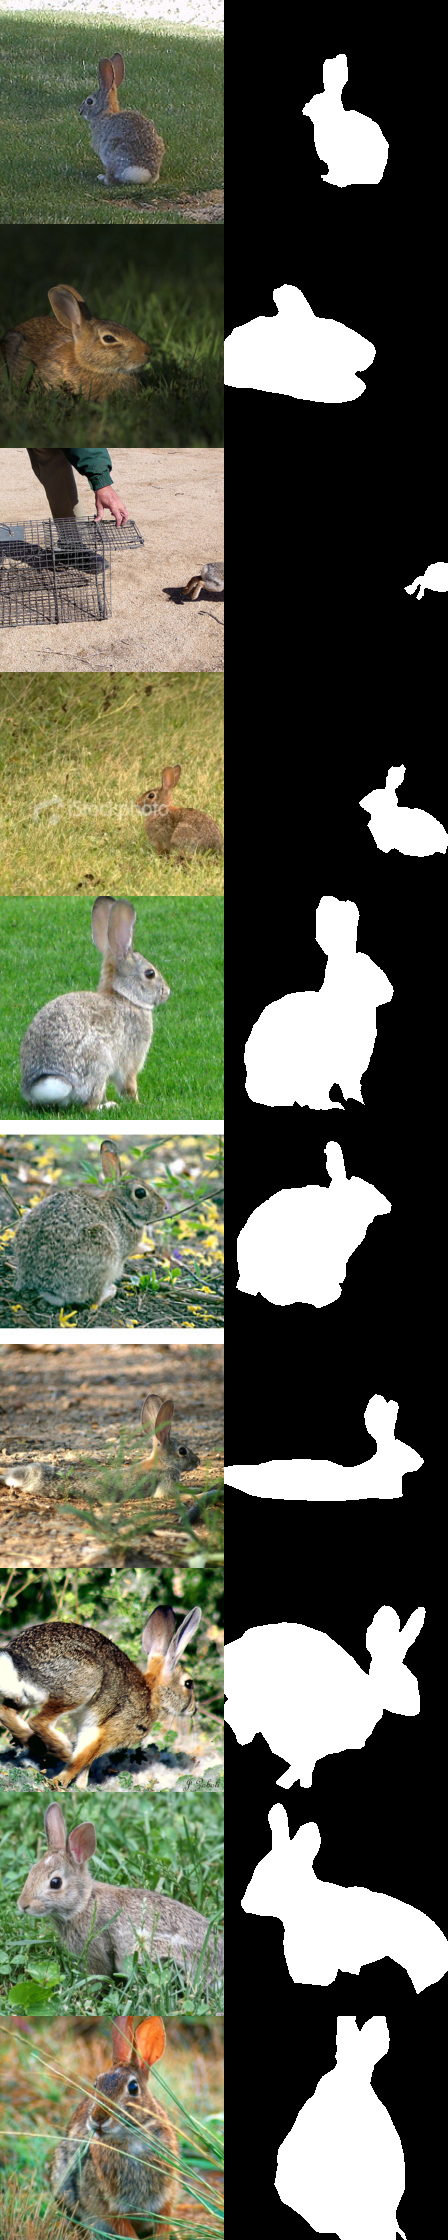

In [6]:
photos = []
for tensor, mask in zip(all_tensors, all_masks):
    photo = torch.cat([tensor, mask], dim=2)
    photos.append(photo)
display(transform.to_pil_image(torch.cat(photos, dim=1)))

# Model Loading

In [6]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval()
resnet_transform = ResNet50_Weights.DEFAULT.transforms()
pipeline = lambda images: torch.stack([resnet_transform(image) for image in images])

In [8]:
proper_data = pipeline(all_images_original)
outputs2 = model(proper_data)
_, preds2 = torch.max(outputs2, 1)
probs2 = torch.nn.functional.softmax(outputs2, dim=1)
[imagenet_classes_dict[str(i.item())][1] for i in preds2]

['wood_rabbit',
 'wood_rabbit',
 'wood_rabbit',
 'wood_rabbit',
 'wood_rabbit',
 'wood_rabbit',
 'wood_rabbit',
 'wood_rabbit',
 'wood_rabbit',
 'wood_rabbit']

# Single Explanations

In [9]:
single_pred = preds2[2].unsqueeze(dim=0)
single_data = proper_data[2].unsqueeze(dim=0)
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(single_data, target=single_pred, n_steps=200)

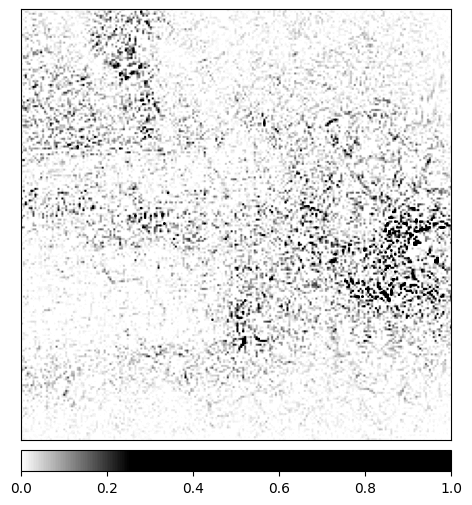

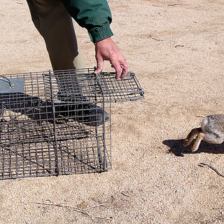

In [10]:
transformed_img = resnet_transform(all_images_original[2])
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
display(all_images[2])

In [11]:
import gc
gc.collect()

155

In [12]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(single_data, nt_samples=5, nt_type='smoothgrad_sq', target=single_pred)

In [13]:
attributions_ig_nt_all = torch.cat([noise_tunnel.attribute(tensor_images[i].unsqueeze(dim=0), nt_samples=5, nt_type='smoothgrad_sq', target=preds2[i].unsqueeze(dim=0)) for i in range(10)], dim=0)

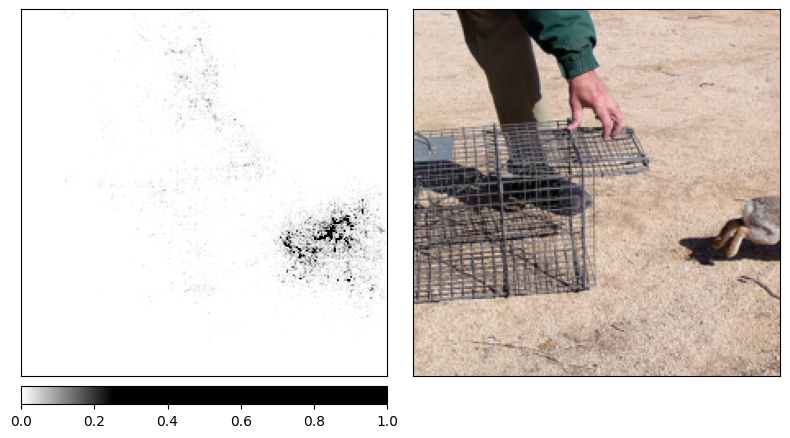

In [14]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [15]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(single_data,
                                       strides = (3, 8, 8),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

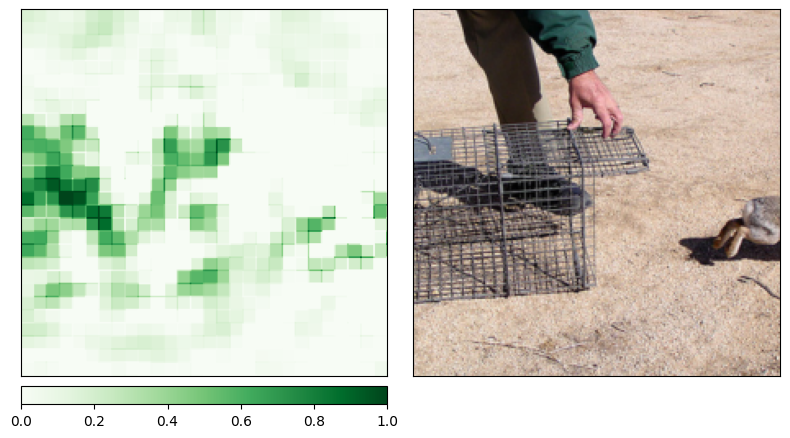

In [16]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["positive", "all"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

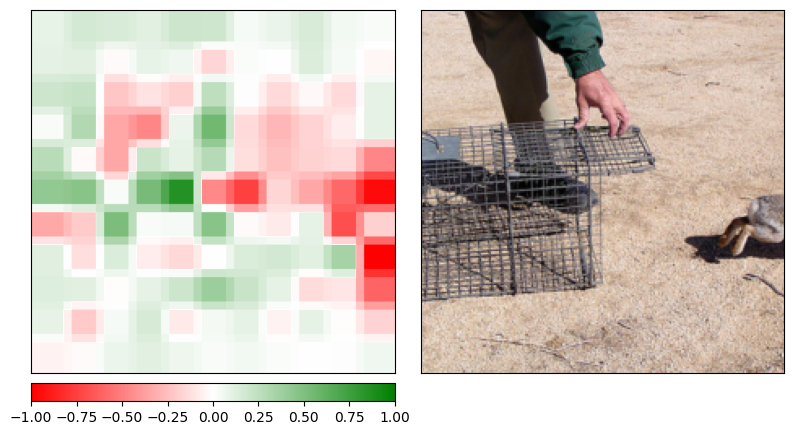

In [17]:
occlusion = Occlusion(model)

attributions_occ2 = occlusion.attribute(single_data,
                                       strides = (3, 20, 20),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 25, 25),
                                       baselines=0)
_2 = viz.visualize_image_attr_multiple(np.transpose(attributions_occ2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

In [18]:
occlusion = Occlusion(model)

attributions_occ_all_25 = occlusion.attribute(tensor_images,
                                        strides = (3, 20, 20),
                                        target = preds2,
                                        sliding_window_shapes = (3, 25, 25),
                                        baselines=0)

attributions_occ_all_15 = occlusion.attribute(tensor_images,
                                           strides = (3, 8, 8),
                                           target = preds2,
                                           sliding_window_shapes = (3, 15, 15),
                                           baselines=0)

In [19]:
saliency = Saliency(model)
attr_saliency = saliency.attribute(tensor_images, target=preds2)

D:\Mini\Inzynierka\XAI_ensemblings_BS_MS\venv\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


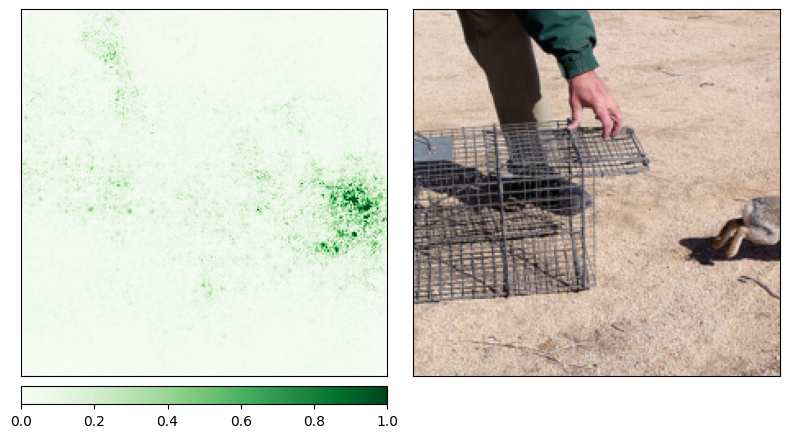

In [20]:
_3 = viz.visualize_image_attr_multiple(np.transpose(attr_saliency[2].numpy(), (1,2,0)),
                                       np.array(all_images[2]),
                                       ["heat_map", "original_image"],
                                       ["positive", "positive"],
                                       show_colorbar=True,
                                       outlier_perc=2,
                                       )

In [21]:
def sample_xai(images):
    if images.shape[0] == 1:
        target = single_pred
    else:
        target = single_pred.repeat(images.shape[0])
    xai = occlusion.attribute(images,
                              strides = (3, 40, 40),
                              target=target,
                              sliding_window_shapes=(3,50, 50),
                              baselines=0)
    return xai
#Metrics.stability(sample_xai, single_data.squeeze(dim=0), single_data.repeat(10,1,1,1))

# Ensembles

In [22]:
x = torch.cat([attributions_occ, attributions_ig_nt])
aggregated1 = Ensemble.basic(x, aggregating_func='avg')
aggregated2 = Ensemble.basic(x, aggregating_func='min')
aggregated3 = Ensemble.basic(x, aggregating_func='max')

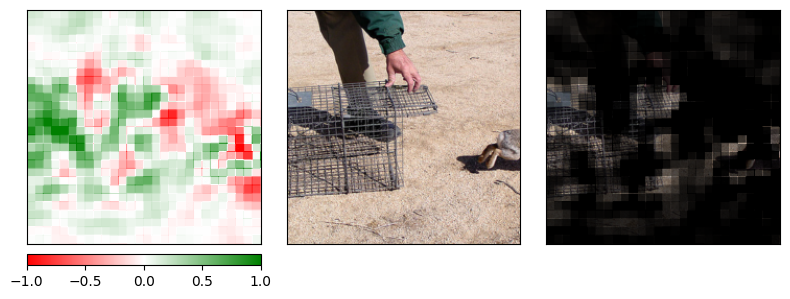

In [23]:
#display(transform.to_pil_image(aggregated1[0]))
_ = viz.visualize_image_attr_multiple(np.transpose(aggregated1.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(all_images[2]),
                                      ["heat_map", "original_image", "masked_image"],
                                      ["all", "positive", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

In [24]:
all_stacked = torch.stack([attributions_occ_all_15, attributions_occ_all_25], dim=1)

In [25]:
attr_agg_avg = Ensemble.basic(all_stacked, aggregating_func='avg')
attr_agg_min = Ensemble.basic(all_stacked, aggregating_func='min')
attr_agg_max = Ensemble.basic(all_stacked, aggregating_func='max')

In [26]:
plt.style.use('fast')

In [27]:
def plot_explanations(images, explanations_dict, classes_predicted,
                      #cmaps=[default_cmap, None, None, None, None, None, None],
                      method = "heat_map"):
    nrow, ncol = len(images), len(explanations_dict.keys())+1
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize=(14, 3*nrow))
    columns_names = ["Original"] + list(explanations_dict.keys())
    for col, col_name in zip(ax[0], columns_names):
        col.title.set_text(col_name)
    for i, img in enumerate(images):
        ax[i,0].xaxis.set_ticks_position("none")
        ax[i,0].yaxis.set_ticks_position("none")
        ax[i,0].set_yticklabels([])
        ax[i,0].set_xticklabels([])
        ax[i,0].imshow(np.array(images[i]), vmin=0, vmax=255)
        ax[i,0].set_ylabel(classes_predicted[i], size='large')
        for j, (col, (key, explanations)) in enumerate(zip(ax[i,1:], explanations_dict.items())):
            #ith image, jth explanation
            #expl = explanations[i,j]
            expl = explanations[j]
            sign = "all"
            cmap=None
            if expl.amin() >= 0:
                sign = "positive"
                cmap = default_cmap
            _ = viz.visualize_image_attr(np.transpose(expl.squeeze().numpy(), (1,2,0)),
                                         original_image=np.array(img),
                                         method=method,
                                         sign=sign,
                                         plt_fig_axis=(fig, col),
                                         show_colorbar=True,
                                         outlier_perc=2,
                                         cmap=cmap,
                                         use_pyplot=False
                                         )
    plt.savefig(f"results/{id}/plots.png")
    plt.show()

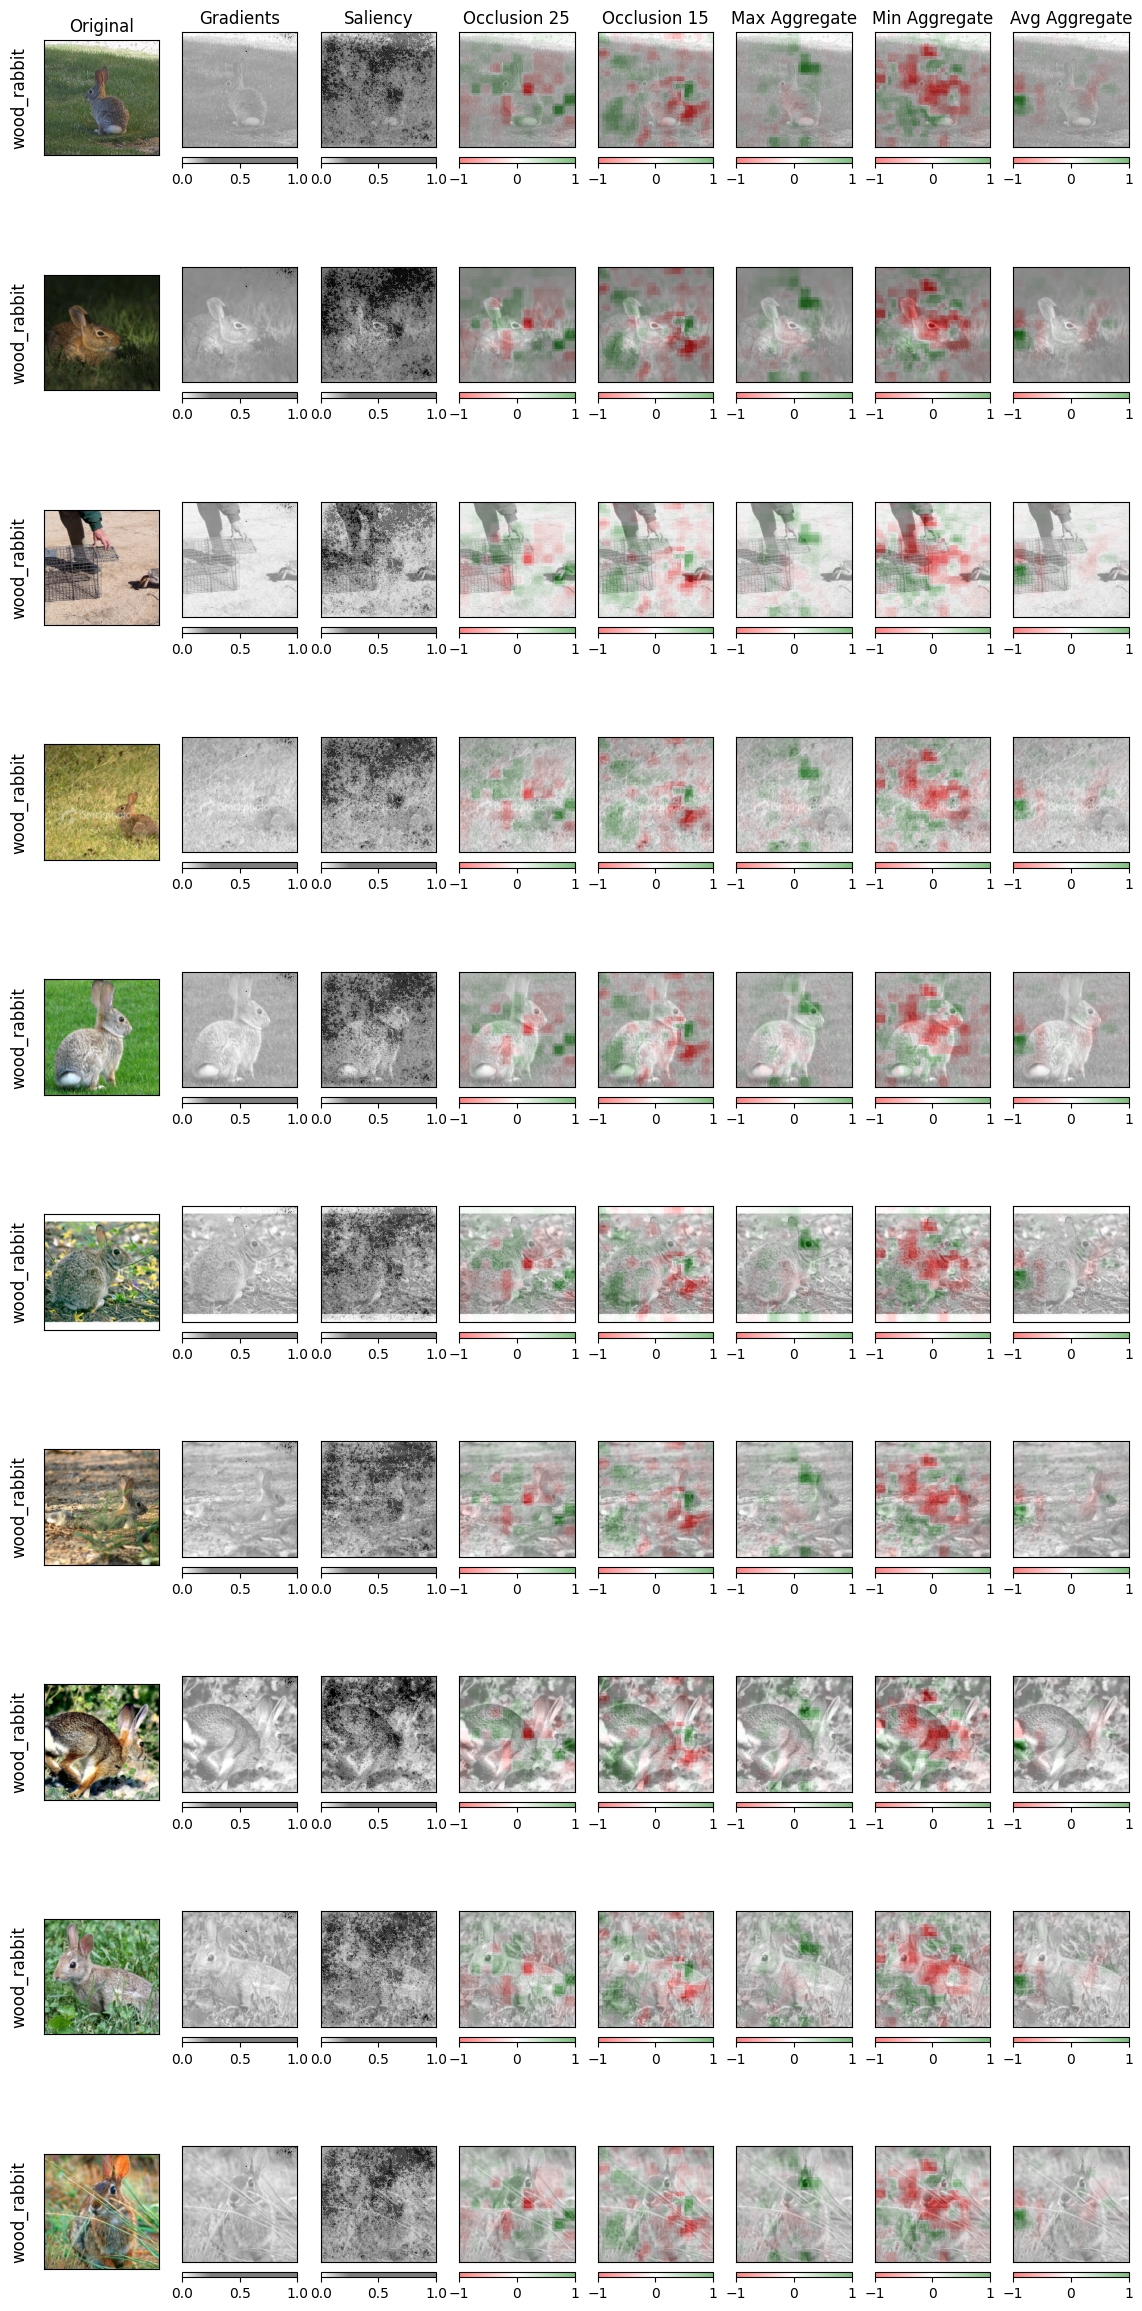

In [28]:
expl_dict = {"Gradients":attributions_ig_nt_all, "Saliency":attr_saliency, "Occlusion 25":attributions_occ_all_25,
             "Occlusion 15":attributions_occ_all_15, "Max Aggregate":attr_agg_max,
             "Min Aggregate":attr_agg_min, "Avg Aggregate":attr_agg_avg}
predicted_names = [imagenet_classes_dict[str(i.item())][1] for i in preds2]
plot_explanations(all_images, expl_dict, predicted_names, method="blended_heat_map")

In [7]:
predict = lambda x: torch.nn.Softmax(dim=0)(model(x))
per_explanation = dict_to_matrix(proper_data, expl_dict, predict, tensor_masks)

In [30]:
per_explanation

DIR0.0  CIR Same0.0  CIR Max0.0  Average Recall0.0  \
Gradients         1.0     0.179563    0.179563           1.000000   
Saliency          1.0     0.179563    0.179563           1.000000   
Occlusion 25      1.0     0.057467   -0.263432           0.634804   
Occlusion 15      1.0     0.091937   -0.321346           0.585397   
Max Aggregate     1.0     0.092057   -0.366344           0.720750   
Min Aggregate     0.9     0.077430   -0.273459           0.499452   
Avg Aggregate     0.8     0.097558   -0.365622           0.612804   

               Average Precision0.0  F1_score0.0    IOU0.0  DIR0.1  \
Gradients                  0.242508     0.370840  0.242508     0.0   
Saliency                   0.242508     0.370840  0.242508     0.3   
Occlusion 25               0.254280     0.331813  0.209269     0.8   
Occlusion 15               0.252196     0.322555  0.205068     0.5   
Max Aggregate              0.244457     0.339265  0.216674     0.8   
Min Aggregate              0.265815     0.308822  0.193426     0.5   
Avg Aggregate              0.253149     0.328481  0.209008     0.8   

               CIR Same0.1  CIR Max0.1  ...  Average Precision0.8  \
Gradients         0.000000    0.000000  ...              0.000000   
Saliency          0.006026   -0.001357  ...              0.040816   
Occlusion 25      0.028190   -0.048777  ...              0.000000   
Occlusion 15      0.017214   -0.036571  ...              0.095153   
Max Aggregate     0.037240   -0.066846  ...              0.095153   
Min Aggregate     0.005208   -0.036866  ...              0.000000   
Avg Aggregate     0.042319   -0.042982  ...              0.100000   

               F1_score0.8    IOU0.8  DIR0.9  CIR Same0.9  CIR Max0.9  \
Gradients              0.0  0.000000     0.0     0.000000    0.000000   
Saliency               0.0  0.000764     0.0    -0.001725   -0.001725   
Occlusion 25           0.0  0.000000     0.0     0.000000    0.000000   
Occlusion 15           0.0  0.042290     0.1    -0.003005   -0.003111   
Max Aggregate          0.0  0.042290     0.1    -0.003005   -0.003111   
Min Aggregate          0.0  0.000000     0.0     0.000000    0.000000   
Avg Aggregate          0.0  0.021784     0.1    -0.003199   -0.003256   

               Average Recall0.9  Average Precision0.9  F1_score0.9    IOU0.9  
Gradients               0.000000              0.000000          0.0  0.000000  
Saliency                0.000386              0.030303          0.0  0.000383  
Occlusion 25            0.000000              0.000000          0.0  0.000000  
Occlusion 15            0.030591              0.100000          0.0  0.030591  
Max Aggregate           0.030591              0.100000          0.0  0.030591  
Min Aggregate           0.000000              0.000000          0.0  0.000000  
Avg Aggregate           0.018656              0.100000          0.0  0.018656  

[7 rows x 70 columns]

In [31]:
per_image = pd.DataFrame()
for i in range(10):
    threshold = i/10
    per_image[f"Average Recall{threshold}"] = torch.mean(torch.stack([Metrics.accordance_recall(expl, tensor_masks, threshold) for expl in expl_dict.values()]), dim=0).numpy()
    per_image[f"Average Precision{threshold}"] = torch.mean(torch.stack([Metrics.accordance_precision(expl, tensor_masks, threshold) for expl in expl_dict.values()]), dim=0).numpy()
per_image["Consistency"] = [Metrics.consistency(expls) for expls in torch.stack(list(expl_dict.values()), dim=1)]
per_image

Average Recall0.0  Average Precision0.0  Average Recall0.1  \
0           0.695771              0.118223           0.070163   
1           0.890972              0.288002           0.032646   
2           0.998014              0.026748           0.747834   
3           0.510657              0.060509           0.027362   
4           0.608641              0.328156           0.037810   
5           0.674028              0.270372           0.027034   
6           0.631099              0.158451           0.104381   
7           0.765056              0.455146           0.128488   
8           0.837717              0.396307           0.049771   
9           0.606912              0.405107           0.032105   

   Average Precision0.1  Average Recall0.2  Average Precision0.2  \
0              0.655524           0.000419              0.285714   
1              0.716241           0.000000              0.000000   
2              0.083180           0.647796              0.179626   
3              0.598997           0.000000              0.000000   
4              0.651063           0.010366              0.816608   
5              0.417710           0.004832              0.279286   
6              0.564109           0.052656              0.629365   
7              0.653225           0.018298              0.730643   
8              0.855343           0.005674              0.428571   
9              0.715642           0.000002              0.142857   

   Average Recall0.3  Average Precision0.3  Average Recall0.4  \
0           0.000000              0.000000           0.000000   
1           0.000000              0.000000           0.000000   
2           0.596369              0.348955           0.486123   
3           0.000000              0.000000           0.000000   
4           0.004865              0.285714           0.000000   
5           0.000000              0.000000           0.000000   
6           0.039223              0.689106           0.029718   
7           0.004886              0.285714           0.000000   
8           0.000000              0.000000           0.000000   
9           0.000000              0.000000           0.000000   

   Average Precision0.4  ...  Average Precision0.5  Average Recall0.6  \
0              0.000000  ...              0.000000           0.000000   
1              0.000000  ...              0.000000           0.000000   
2              0.468030  ...              0.621071           0.339900   
3              0.000000  ...              0.000000           0.000000   
4              0.000000  ...              0.000000           0.000000   
5              0.000000  ...              0.000000           0.000000   
6              0.727913  ...              0.831121           0.011171   
7              0.000000  ...              0.000000           0.000000   
8              0.000000  ...              0.000000           0.000000   
9              0.000000  ...              0.000000           0.000000   

   Average Precision0.6  Average Recall0.7  Average Precision0.7  \
0              0.000000           0.000000              0.000000   
1              0.000000           0.000000              0.000000   
2              0.673913           0.292336              0.680215   
3              0.000000           0.000000              0.000000   
4              0.000000           0.000000              0.000000   
5              0.000000           0.000000              0.000000   
6              0.857143           0.000000              0.000000   
7              0.000000           0.000000              0.000000   
8              0.000000           0.000000              0.000000   
9              0.000000           0.000000              0.000000   

   Average Recall0.8  Average Precision0.8  Average Recall0.9  \
0           0.000000              0.000000           0.000000   
1           0.000000              0.000000           0.000000   
2           0.155714              0.473032           0.114606   
3        

In [32]:
a=expl_dict
with open(f'results/{id}/explanations.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
per_explanation.to_csv(f'results/{id}/per_expl.csv')
per_image.to_csv(f'results/{id}/per_image.csv')
with open(f'results/{id}/explanations.pickle', 'rb') as handle:
    b = pickle.load(handle)
b.keys()

dict_keys(['Gradients', 'Saliency', 'Occlusion 25', 'Occlusion 15', 'Max Aggregate', 'Min Aggregate', 'Avg Aggregate'])